## Set up libraries etc

In [36]:
import os
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
query = '''

--find COVID-19 lab test concepts (only one in this database)
WITH lab_test_concepts as (
SELECT *
FROM concept
WHERE concept_code IN ('94531-1') AND vocabulary_id = 'LOINC'),
 
--find standard COVID-19 dx code
standard_dx as (
SELECT distinct concept_id_2
FROM concept c JOIN concept_relationship cr ON c.concept_id = cr.concept_id_1
WHERE c.concept_code = 'U07.1' AND cr.relationship_id = 'Maps to'  
),
 
--find patients with COVID using the diagnosis code
covid_dx_pts as (
SELECT distinct co.person_id, co.condition_start_date
FROM condition_occurrence co JOIN standard_dx sd ON co.condition_concept_id =
      sd.concept_id_2
),
 
--find patients with COVID using the lab test
covid_lab_pts as (
SELECT m.person_id, m.measurement_date
FROM measurement m JOIN lab_test_concepts lt ON m.measurement_concept_id = lt.concept_id
WHERE m.value_source_value = 'Detected (qualifier value)'
),
 
--union the lab and diagnosis cohorts
all_patients as (
select person_id, measurement_date as cov_dt from covid_lab_pts
      UNION
select person_id, condition_start_date as cov_dt from covid_dx_pts
),
 
 
--find all patients hospitalized in the correct date range
hospitalized as (
SELECT vo.person_id, visit_occurrence_id, ap.cov_dt, vo.visit_start_date, vo.visit_end_date
FROM visit_occurrence vo JOIN all_patients ap ON vo.person_id = ap.person_id
      AND vo.visit_start_date - ap.cov_dt between -7 and 14
      AND vo.visit_concept_id = 9201
),
 
--find patients with ECMO or ventilator during their hospitalization
ecmo_vent as (
select distinct po.person_id, h.cov_dt
from procedure_occurrence po JOIN hospitalized h ON po.visit_occurrence_id = h.visit_occurrence_id
where po.procedure_concept_id IN (4337616,2893766,4082243,45889042,4140765,4219858,4303945,
                                       4337615,4337617,4337045,44515633,4013354,4287922,4235361,
                                          45887795,2805870,4174085,4283807,2813710,4325601,4134538,
                                          4339623,4353715,4335584,4179373,4251737,4335481,2314000,
                                          4072633,2800859,4149878,40487536,42738852,4335583,4031379,
                                          765576,44791135,4308797,4259233,37116698,2788037,44808555,
                                          4335585,4232891,2007912,2834015,44509482,2788018,4056812,
                                          2106469,4080957,2867784,2788038,4301549,4134853,4119642,
                                          4168966,4230167,4237618,2788023,46273390,2314001,2788028,
                                          40481547,4058031,4287921,2788036,4026054,2108681,42738853,
                                          4229714,37116689,46257680,46257586,46257469,46257399,46257682,
                                          46257440,4338595,46257398,46257585,46257511,46257438,2002247,
                                          46257683,46257730,46257439,46257397,46257685,37206603,46257513,
                                          46257684,46257400,1531630,2787821,46257441,46257468,46257512,
                                          44811012,37206602,46257510,46257544,37206601,46257729,2787820,
                                          1531631,4052536,46257467,44515635,1531632,46257543,46257466)
),
 
vasopress as (
select distinct de.person_id, h.cov_dt
from drug_exposure de JOIN hospitalized h ON de.visit_occurrence_id = h.visit_occurrence_id
where drug_concept_id IN (40072394,46287545,42628989,19076659,964320,1368671,42902898,1593970,
                                   1593980,42799670,19136059,42628991,42628988,1321364,19111072,963889,
                                   42903217,35606572,35202043,35758740,46275915,1337750,740268,42799674,
                                   1321341,44032830,740269,40240695,42628990,42799685,1593981,42628995,
                                   42902848,35606562,1719037,19056879,964327,35606567,35606561,1343916,
                                   35606568,1719038,1321363,19091005,46287575,1719039,46287547,35606570,
                                   40074086,35606563,42628993,40071162,19076658,37499754,45775841,
                                   35606558,35606565,35201925,740243,1507838,740244,42628996,35606564,
                                   964321,42707287,1593969,1135766,40865800,1344055,35606569,35782395,
                                   35606566,42707286,42799684,1593464,45776267,1337860,35201924,1593459,
                                   19020994,1337720,35202042,1507835,19079625,35606571,19058101,40087301,
                                   19076660,1344052,40929934,19079028,1594056,46287544,42799044,19039813,
                                   36885592,964326,35603731,40038600,35867254,40035704,19036210,1361711,
                                   46287548,19040856,19101883,1593971,41252710,42628994,1362232)
),
 
--union the ecmo, vent, and vasopressor patients in a single table
all_severe as (
select person_id, cov_dt, 'severe' as category from ecmo_vent
      UNION
select person_id, cov_dt, 'severe' as category from vasopress
),
 
--grab patients who were hospitalized but not severe for moderate category
all_mod as (
select h.person_id, h.cov_dt, 'moderate' as category
from hospitalized h LEFT JOIN all_severe asv ON h.person_id = asv.person_id
where asv.person_id is null
),
 
--grab everyone with covid but not hospitalized
all_mild as (
select ap.person_id, ap.cov_dt, 'mild' as category
from all_patients ap LEFT JOIN hospitalized h ON ap.person_id = h.person_id
WHERE h.person_id is null
),
 
--flag every patient with their severity category
patients_w_sev as (
select * from all_severe UNION select * from all_mod UNION select * from all_mild
),
 
--add demographic information for each patient
patients_w_demos as (
select ps.*, racecon.concept_name as race_name, gencon.concept_name as gen_name,
      floor(extract(day from (current_date - p.birth_datetime))/365.25) as current_age
from person p JOIN concept racecon ON p.race_concept_id = racecon.concept_id
      JOIN concept gencon ON p.gender_concept_id = gencon.concept_id
      JOIN patients_w_sev ps ON p.person_id = ps.person_id
),
 
--pull all numeric lab values for all patients between 0 and 14 days from their covid diagnosis date
all_meas as (
select pw.*, con.concept_name as measurement_name, m.measurement_date, m.value_as_number,
      unit.concept_name as unit_name
from measurement m JOIN concept con ON m.measurement_concept_id = con.concept_id
      JOIN concept unit ON m.unit_concept_id = unit.concept_id
      JOIN patients_w_demos pw ON pw.person_id = m.person_id
WHERE (m.measurement_date - pw.cov_dt) between 0 and 14 and m.value_as_number is not null),
 
--find the most common labs
toplabs as (
select measurement_name, count(*) as meascount
from all_meas
group by measurement_name
order by meascount desc
),
 
final_tbl as (
--limit result set to the most common labs
select a.*
from all_meas a JOIN toplabs t ON a.measurement_name = t.measurement_name and t.meascount >= 214000
),
 
people_only as (
select distinct person_id, category
from final_tbl),
 
people_union as (
select distinct person_id, category, floor(random() * 6000 + 1)::int as rannum
from people_only
where category = 'severe'
 
UNION
 
select distinct person_id, category, floor(random() * 12000 + 1)::int as rannum
from people_only
where category = 'moderate'
 
UNION
 
select distinct person_id, category, floor(random() * 100000 + 1)::int as rannum
from people_only
where category = 'mild'
)
 
select f.*
from people_union p JOIN final_tbl f ON p.person_id = f.person_id
where (p.category = 'severe' AND rannum <= 450)
     OR (p.category = 'moderate' AND rannum <= 400)
     OR (p.category = 'mild' AND rannum <= 1500)

'''

## Read the data

In [41]:
person_data = pd.read_sql_query(query, engine)
person_data

,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name
0,41,2020-03-04,mild,White,FEMALE,37.0,Diastolic blood pressure,2020-03-04,71.0,millimeter mercury column
1,41,2020-03-04,mild,White,FEMALE,37.0,Body temperature,2020-03-04,41.6,degree Celsius
2,41,2020-03-04,mild,White,FEMALE,37.0,Respiratory rate,2020-03-04,25.5,per minute
3,41,2020-03-04,mild,White,FEMALE,37.0,Oxygen saturation in Arterial blood,2020-03-04,88.6,percent
4,41,2020-03-04,mild,White,FEMALE,37.0,Systolic blood pressure,2020-03-04,115.0,millimeter mercury column
...,...,...,...,...,...,...,...,...,...,...
208432,124114,2020-03-13,mild,White,MALE,34.0,Body weight,2020-03-13,80.5,kilogram
208433,124114,2020-03-13,mild,White,MALE,34.0,Systolic blood pressure,2020-03-13,128.0,millimeter mercury column
208434,124114,2020-03-13,mild,White,MALE,34.0,Oxygen saturation in Arterial blood,2020-03-13,81.7,percent
208435,124114,2020-03-13,mild,White,MALE,34.0,Respiratory rate,2020-03-13,17.2,per minute


## Write the data to a CSV file

In [42]:
person_data.to_csv("data_covid.csv", index = False)

## Once you have your random selection of data saved, do not run the data retrieval query again, rather read teh CSV file taht yo have saved

In [44]:
person_data = pd.read_csv("data_covid.csv")
person_data

,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name
0,41,2020-03-04,mild,White,FEMALE,37.0,Diastolic blood pressure,2020-03-04,71.0,millimeter mercury column
1,41,2020-03-04,mild,White,FEMALE,37.0,Body temperature,2020-03-04,41.6,degree Celsius
2,41,2020-03-04,mild,White,FEMALE,37.0,Respiratory rate,2020-03-04,25.5,per minute
3,41,2020-03-04,mild,White,FEMALE,37.0,Oxygen saturation in Arterial blood,2020-03-04,88.6,percent
4,41,2020-03-04,mild,White,FEMALE,37.0,Systolic blood pressure,2020-03-04,115.0,millimeter mercury column
...,...,...,...,...,...,...,...,...,...,...
208432,124114,2020-03-13,mild,White,MALE,34.0,Body weight,2020-03-13,80.5,kilogram
208433,124114,2020-03-13,mild,White,MALE,34.0,Systolic blood pressure,2020-03-13,128.0,millimeter mercury column
208434,124114,2020-03-13,mild,White,MALE,34.0,Oxygen saturation in Arterial blood,2020-03-13,81.7,percent
208435,124114,2020-03-13,mild,White,MALE,34.0,Respiratory rate,2020-03-13,17.2,per minute


## How many patients?

In [45]:
print(f"Number of patients = {len(person_data['person_id'].unique())}")

Number of patients = 1710


## How many unique categories are there?

In [46]:
uniq_cats = person_data['category'].unique()
print(f"Number of unique categories = {len(uniq_cats)}")
print(uniq_cats)

Number of unique categories = 3
['mild' 'moderate' 'severe']


## How many measurements are there in each of the categories?

In [107]:
mild_count = len(person_data[person_data['category'] == 'mild'])
print(f"Number of records with mild COVID is {mild_count}")

moderate_count = len(person_data[person_data['category'] == 'moderate'])
print(f"Number of records with moderate COVID is {moderate_count}")  

severe_count = len(person_data[person_data['category'] == 'severe'])
print(f"Number of records with severe COVID is {severe_count}") 


Number of records with mild COVID is 7185
Number of records with moderate COVID is 130071
Number of records with severe COVID is 71181


In [177]:
# Count of patients by severity and sex
severity_sex_counts = person_data.groupby(['category', 'gen_name']).size().unstack(fill_value=0)

# Display the results
print("Counts by Sex:")
print(severity_sex_counts)



Counts by Sex:
gen_name  FEMALE   MALE
category               
mild        3787   3398
moderate   71099  58972
severe     30453  40728


In [178]:
# Count of each severity
mild_count = len(person_data[person_data['category'] == 'mild'])
print(f"Number of records with mild COVID is {mild_count}")

moderate_count = len(person_data[person_data['category'] == 'moderate'])
print(f"Number of records with moderate COVID is {moderate_count}")  

severe_count = len(person_data[person_data['category'] == 'severe'])
print(f"Number of records with severe COVID is {severe_count}") 
print("")

# Count of patients by severity and sex
severity_sex_counts = person_data.groupby(['category', 'gen_name']).size().unstack(fill_value=0)

# Count of patients by severity and age group
def age_group(age):
    if age < 18:
        return '<18'
    elif age <= 45:
        return '18 - 45'
    elif age <= 65:
        return '46 - 65'
    else:
        return '>65'

person_data['Age_Group'] = person_data['current_age'].apply(age_group)
severity_age_counts = person_data.groupby(['category', 'Age_Group']).size().unstack(fill_value=0)

# Count of patients by severity and race
severity_race_counts = person_data.groupby(['category', 'race_name']).size().unstack(fill_value=0)


# Display the results
print("Mild COVID")
print(severity_sex_counts.loc['mild'])
print(severity_age_counts.loc['mild'])
print(severity_race_counts.loc['mild'])
print("")

print("Moderate COVID")
print(severity_sex_counts.loc['moderate'])
print(severity_age_counts.loc['moderate'])
print(severity_race_counts.loc['moderate'])
print("")

print("Severe COVID")
print(severity_sex_counts.loc['severe'])
print(severity_age_counts.loc['severe'])
print(severity_race_counts.loc['severe'])


Number of records with mild COVID is 7185
Number of records with moderate COVID is 130071
Number of records with severe COVID is 71181

Mild COVID
gen_name
FEMALE    3787
MALE      3398
Name: mild, dtype: int64
Age_Group
18 - 45    2729
46 - 65    1703
<18        1478
>65        1275
Name: mild, dtype: int64
race_name
Asian                         467
Black or African American     506
No matching concept            61
White                        6151
Name: mild, dtype: int64

Moderate COVID
gen_name
FEMALE    71099
MALE      58972
Name: moderate, dtype: int64
Age_Group
18 - 45    35353
46 - 65    48447
<18         6376
>65        39895
Name: moderate, dtype: int64
race_name
Asian                         10613
Black or African American     10732
No matching concept             817
White                        107909
Name: moderate, dtype: int64

Severe COVID
gen_name
FEMALE    30453
MALE      40728
Name: severe, dtype: int64
Age_Group
18 - 45     7070
46 - 65    21805
<18          750


## How many unique types of labs/vitals?

In [48]:
labs_vitals = person_data['measurement_name'].unique()
print(f"Number of Labs and Vitals = {len(labs_vitals)}")
print(labs_vitals)

Number of Labs and Vitals = 22
['Diastolic blood pressure' 'Body temperature' 'Respiratory rate'
 'Oxygen saturation in Arterial blood' 'Systolic blood pressure'
 'Body weight' 'Heart rate'
 'Hematocrit [Volume Fraction] of Blood by Automated count'
 'Erythrocytes [#/volume] in Blood by Automated count'
 'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma'
 'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma'
 'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma'
 'Bilirubin.total [Mass/volume] in Serum or Plasma'
 'Albumin [Mass/volume] in Serum or Plasma'
 'MCHC [Mass/volume] by Automated count'
 'Hemoglobin [Mass/volume] in Blood'
 'Platelets [#/volume] in Blood by Automated count'
 'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (MDRD)'
 'Protein [Mass/volume] in Serum or Plasma'
 'MCH [Entitic mass] by Automated count'
 'MCV [Entitic volume] by Autom

#### First confirm that the dates in `person_data` are indeed strings

In [49]:
person_data.dtypes

person_id             int64
cov_dt               object
category             object
race_name            object
gen_name             object
current_age         float64
measurement_name     object
measurement_date     object
value_as_number     float64
unit_name            object
dtype: object

In [50]:
type(person_data['cov_dt'])

pandas.core.series.Series

In [51]:
type(person_data.iloc[0]['cov_dt'])

str

#### Let us change the dates in `person_data` to be of type date_time

In [52]:
person_data["measurement_date"] = pd.to_datetime(person_data["measurement_date"])
type(person_data.iloc[0]["measurement_date"])

pandas._libs.tslibs.timestamps.Timestamp

In [53]:
person_data["cov_dt"] = pd.to_datetime(person_data["cov_dt"])
type(person_data.iloc[0]["cov_dt"])

pandas._libs.tslibs.timestamps.Timestamp

#### Add a column to `person_data` that is the difference in days between the `measurement_date` and `cov_dt`

In [54]:
person_data['ddays'] = (person_data["measurement_date"] - person_data["cov_dt"])
type(person_data.iloc[0]["ddays"])

pandas._libs.tslibs.timedeltas.Timedelta

#### `ddays` may not be usable as an index as it is. Let us make it of type iteger 

In [55]:
person_data['ddays'] = (person_data["measurement_date"] - person_data["cov_dt"]).dt.days
type(person_data.iloc[0]["ddays"])

numpy.int64

#### Do a quick check that the dataframe looks right

In [56]:
person_data.head()

,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name,ddays
0,41,2020-03-04,mild,White,FEMALE,37.0,Diastolic blood pressure,2020-03-04,71.0,millimeter mercury column,0
1,41,2020-03-04,mild,White,FEMALE,37.0,Body temperature,2020-03-04,41.6,degree Celsius,0
2,41,2020-03-04,mild,White,FEMALE,37.0,Respiratory rate,2020-03-04,25.5,per minute,0
3,41,2020-03-04,mild,White,FEMALE,37.0,Oxygen saturation in Arterial blood,2020-03-04,88.6,percent,0
4,41,2020-03-04,mild,White,FEMALE,37.0,Systolic blood pressure,2020-03-04,115.0,millimeter mercury column,0


## Task 2 Developing a way to compute the statistics needed to create the visualization
* Let us say we want to create a visuzlization similar to eFigure 4 in the Bennett paper supplement
* Each plot (Axes in Matplotlib lingo) in this figure is a 2 d plot with
    * days since infected on the x-axis
    * median of lab/vital-sign value on the y-axis
    * there are separate curves for each diseases severity category - mild, moderate, severe or mortality/hospice (we dont have the last one in our data)
    * max and min values for each of these is shown as a bar for each day
![Bennett-eFigure-4](Bennett-eFigure-4.png)

In [57]:
body_temp = person_data[(person_data['category'] == 'mild') & (person_data['measurement_name'] == 'Body temperature')]
body_temp

,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name,ddays
1,41,2020-03-04,mild,White,FEMALE,37.0,Body temperature,2020-03-04,41.6,degree Celsius,0
13,114,2020-02-29,mild,White,FEMALE,57.0,Body temperature,2020-02-29,38.2,degree Celsius,0
335,282,2020-02-19,mild,White,MALE,26.0,Body temperature,2020-02-19,41.5,degree Celsius,0
341,394,2020-03-11,mild,White,FEMALE,17.0,Body temperature,2020-03-11,39.0,degree Celsius,0
348,409,2020-03-06,mild,White,MALE,36.0,Body temperature,2020-03-06,38.6,degree Celsius,0
...,...,...,...,...,...,...,...,...,...,...,...
208134,123713,2020-03-07,mild,White,MALE,65.0,Body temperature,2020-03-07,39.5,degree Celsius,0
208140,123852,2020-03-05,mild,White,MALE,47.0,Body temperature,2020-03-05,38.1,degree Celsius,0
208420,123896,2020-03-07,mild,White,FEMALE,50.0,Body temperature,2020-03-07,38.5,degree Celsius,0
208427,123955,2020-03-10,mild,White,MALE,72.0,Body temperature,2020-03-10,39.2,degree Celsius,0


## Look at another category

In [58]:
body_temp = person_data[(person_data['category'] == 'severe') & (person_data['measurement_name'] == 'Body temperature')]
body_temp

,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name,ddays
754,1045,2020-03-08,severe,White,MALE,84.0,Body temperature,2020-03-13,39.7,degree Celsius,5
769,1045,2020-03-08,severe,White,MALE,84.0,Body temperature,2020-03-12,38.0,degree Celsius,4
784,1045,2020-03-08,severe,White,MALE,84.0,Body temperature,2020-03-11,39.2,degree Celsius,3
799,1045,2020-03-08,severe,White,MALE,84.0,Body temperature,2020-03-10,40.2,degree Celsius,2
814,1045,2020-03-08,severe,White,MALE,84.0,Body temperature,2020-03-09,40.9,degree Celsius,1
...,...,...,...,...,...,...,...,...,...,...,...
208045,123499,2020-03-03,severe,White,FEMALE,54.0,Body temperature,2020-03-07,39.1,degree Celsius,4
208060,123499,2020-03-03,severe,White,FEMALE,54.0,Body temperature,2020-03-06,38.5,degree Celsius,3
208067,123499,2020-03-03,severe,White,FEMALE,54.0,Body temperature,2020-03-03,41.1,degree Celsius,0
208076,123499,2020-03-03,severe,White,FEMALE,54.0,Body temperature,2020-03-05,41.1,degree Celsius,2


In [59]:
body_temp.groupby("ddays")['value_as_number'].mean()

ddays
0     40.028883
1     39.974038
2     40.038164
3     39.748309
4     40.111739
5     39.973444
6     40.050417
7     40.006584
8     40.060581
9     39.894118
10    39.923737
11    39.895055
12    39.769872
13    39.851538
14    39.855446
Name: value_as_number, dtype: float64

## Let us do a quick sanity check

In [60]:
x = body_temp[body_temp['ddays'] == 0]['value_as_number']
x.mean()

40.028883495145635

In [134]:
temp_stats = body_temp.groupby("ddays")['value_as_number'].agg(['min', 'max', 'mean', 'median', 'count'])
temp_stats

,min,max,mean,median,count
ddays,,,,,
0,12.3,196.6,77.011504,79.9,452
7,12.9,114.0,59.180000,66.0,5
13,14.0,129.0,73.550000,78.0,10


## So we can now put all this together in a function that:
* will be passed the `person_data` data frame. the `category` for which we are calculating the stats and the `measurement_name` we are interested in
* and will return a data frame with the max, min, mean, median and count for each day

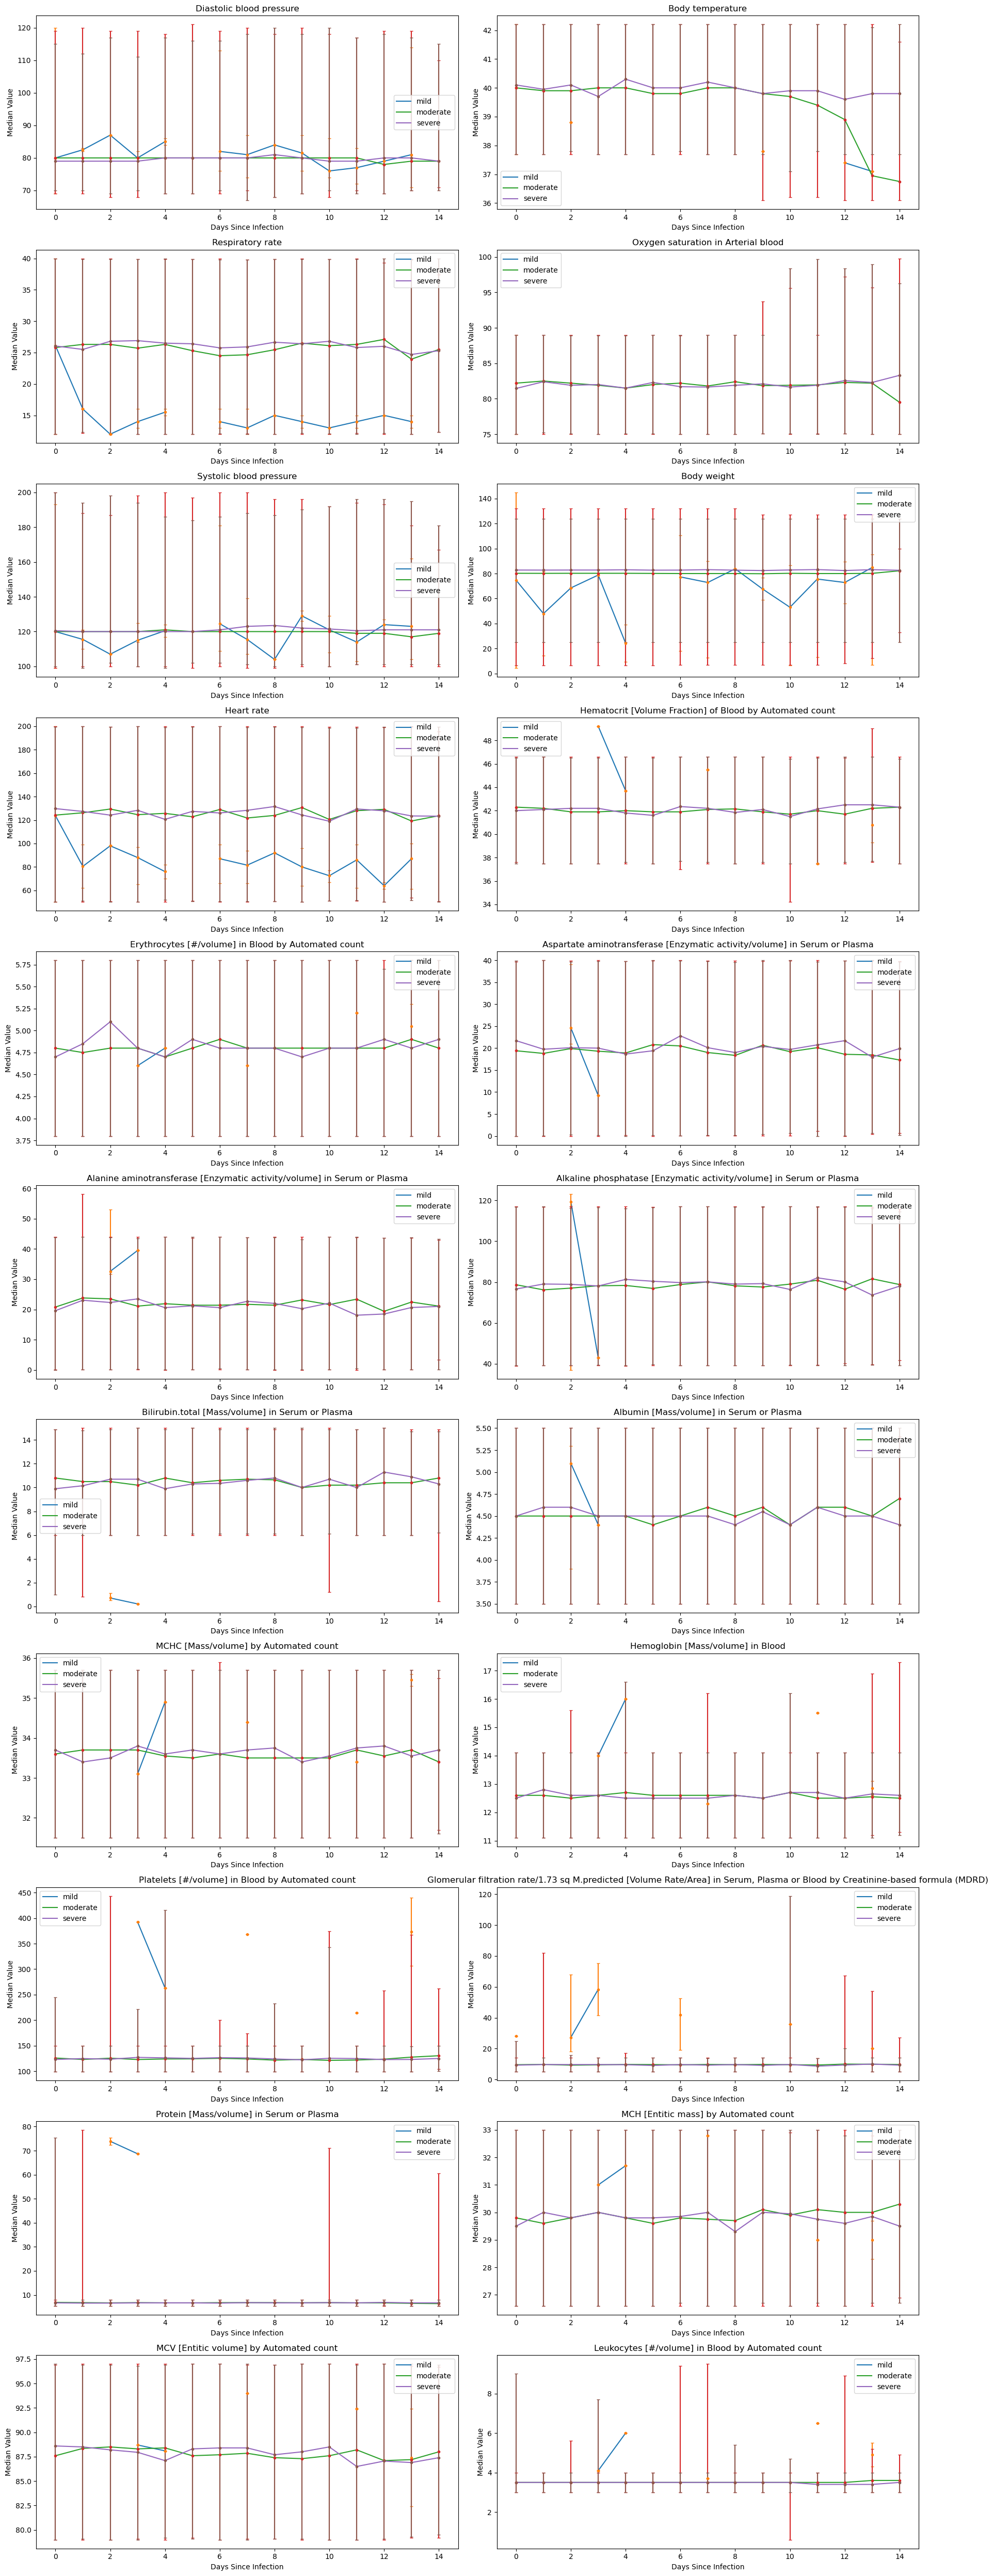

In [278]:
import matplotlib.pyplot as plt
import pandas as pd

# Define a function to calculate statistics
def get_stats(df, cat, meas):
    '''Compute the maximum, minimum, and median
    values by days since disease start for measurement_name = meas
    and category = cat for the data frame df'''
    
    df_stats = df[(df["category"] == cat) & (df["measurement_name"] == meas)].groupby("ddays")["value_as_number"].agg(['max', 'min', 'median'])
    return df_stats

# Define the list of measurements
measurement_names = [
    'Diastolic blood pressure', 'Body temperature', 'Respiratory rate',
    'Oxygen saturation in Arterial blood', 'Systolic blood pressure',
    'Body weight', 'Heart rate',
    'Hematocrit [Volume Fraction] of Blood by Automated count',
    'Erythrocytes [#/volume] in Blood by Automated count',
    'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma',
    'Bilirubin.total [Mass/volume] in Serum or Plasma',
    'Albumin [Mass/volume] in Serum or Plasma',
    'MCHC [Mass/volume] by Automated count',
    'Hemoglobin [Mass/volume] in Blood',
    'Platelets [#/volume] in Blood by Automated count',
    'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (MDRD)',
    'Protein [Mass/volume] in Serum or Plasma',
    'MCH [Entitic mass] by Automated count',
    'MCV [Entitic volume] by Automated count',
    'Leukocytes [#/volume] in Blood by Automated count'
]



# Set up the subplot grid
plt.figure(figsize=(18, 50))

# Iterate over each measurement
for i, measurement in enumerate(measurement_names, start=1):
    plt.subplot(11, 2, i)
    plt.title(measurement)
    plt.xlabel('Days Since Infection')
    plt.ylabel('Median Value')
    
    # Create a DataFrame to hold median, max, and min values for each category
    median_values = pd.DataFrame(range(15), columns=['ddays'])

    # Calculate median, max, and min for each category
    for cat in ['mild', 'moderate', 'severe']:
        stats = get_stats(person_data, cat, measurement)
        median_values[cat + '_median'] = stats['median']
        median_values[cat + '_max'] = stats['max']
        median_values[cat + '_min'] = stats['min']

        # Plot median values
        plt.plot(median_values['ddays'], median_values[cat + '_median'], label=cat)

        # Plot error bars for max and min values
        plt.errorbar(median_values['ddays'], median_values[cat + '_median'], 
                     yerr=[median_values[cat + '_median'] - median_values[cat + '_min'], 
                           median_values[cat + '_max'] - median_values[cat + '_median']], 
                     fmt='.', capsize=2, label=None)

            
    plt.legend()  # Add legend for each subplot

plt.tight_layout()
plt.show()


In [256]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate median, max, and min values for each test and each severity category
median_values = person_data.groupby(['measurement_name', 'category'])['value_as_number'].median().unstack()
max_values = person_data.groupby(['measurement_name', 'category'])['value_as_number'].max().unstack()
min_values = person_data.groupby(['measurement_name', 'category'])['value_as_number'].min().unstack()

# Display the results
print("Median values:")
print(median_values)
print("\nMax values:")
print(max_values)
print("\nMin values:")
print(min_values)





Median values:
category                                              mild  moderate  severe
measurement_name                                                            
Alanine aminotransferase [Enzymatic activity/vo...   36.05     21.90   21.00
Albumin [Mass/volume] in Serum or Plasma              4.75      4.50    4.50
Alkaline phosphatase [Enzymatic activity/volume...   81.15     78.35   78.85
Aspartate aminotransferase [Enzymatic activity/...   22.80     19.50   20.10
Bilirubin.total [Mass/volume] in Serum or Plasma      0.60     10.50   10.40
Body temperature                                     39.90     39.80   40.00
Body weight                                          74.75     80.00   82.80
Diastolic blood pressure                             80.00     80.00   79.00
Erythrocytes [#/volume] in Blood by Automated c...    4.80      4.80    4.80
Glomerular filtration rate/1.73 sq M.predicted ...   35.70      9.60    9.50
Heart rate                                          119.15   

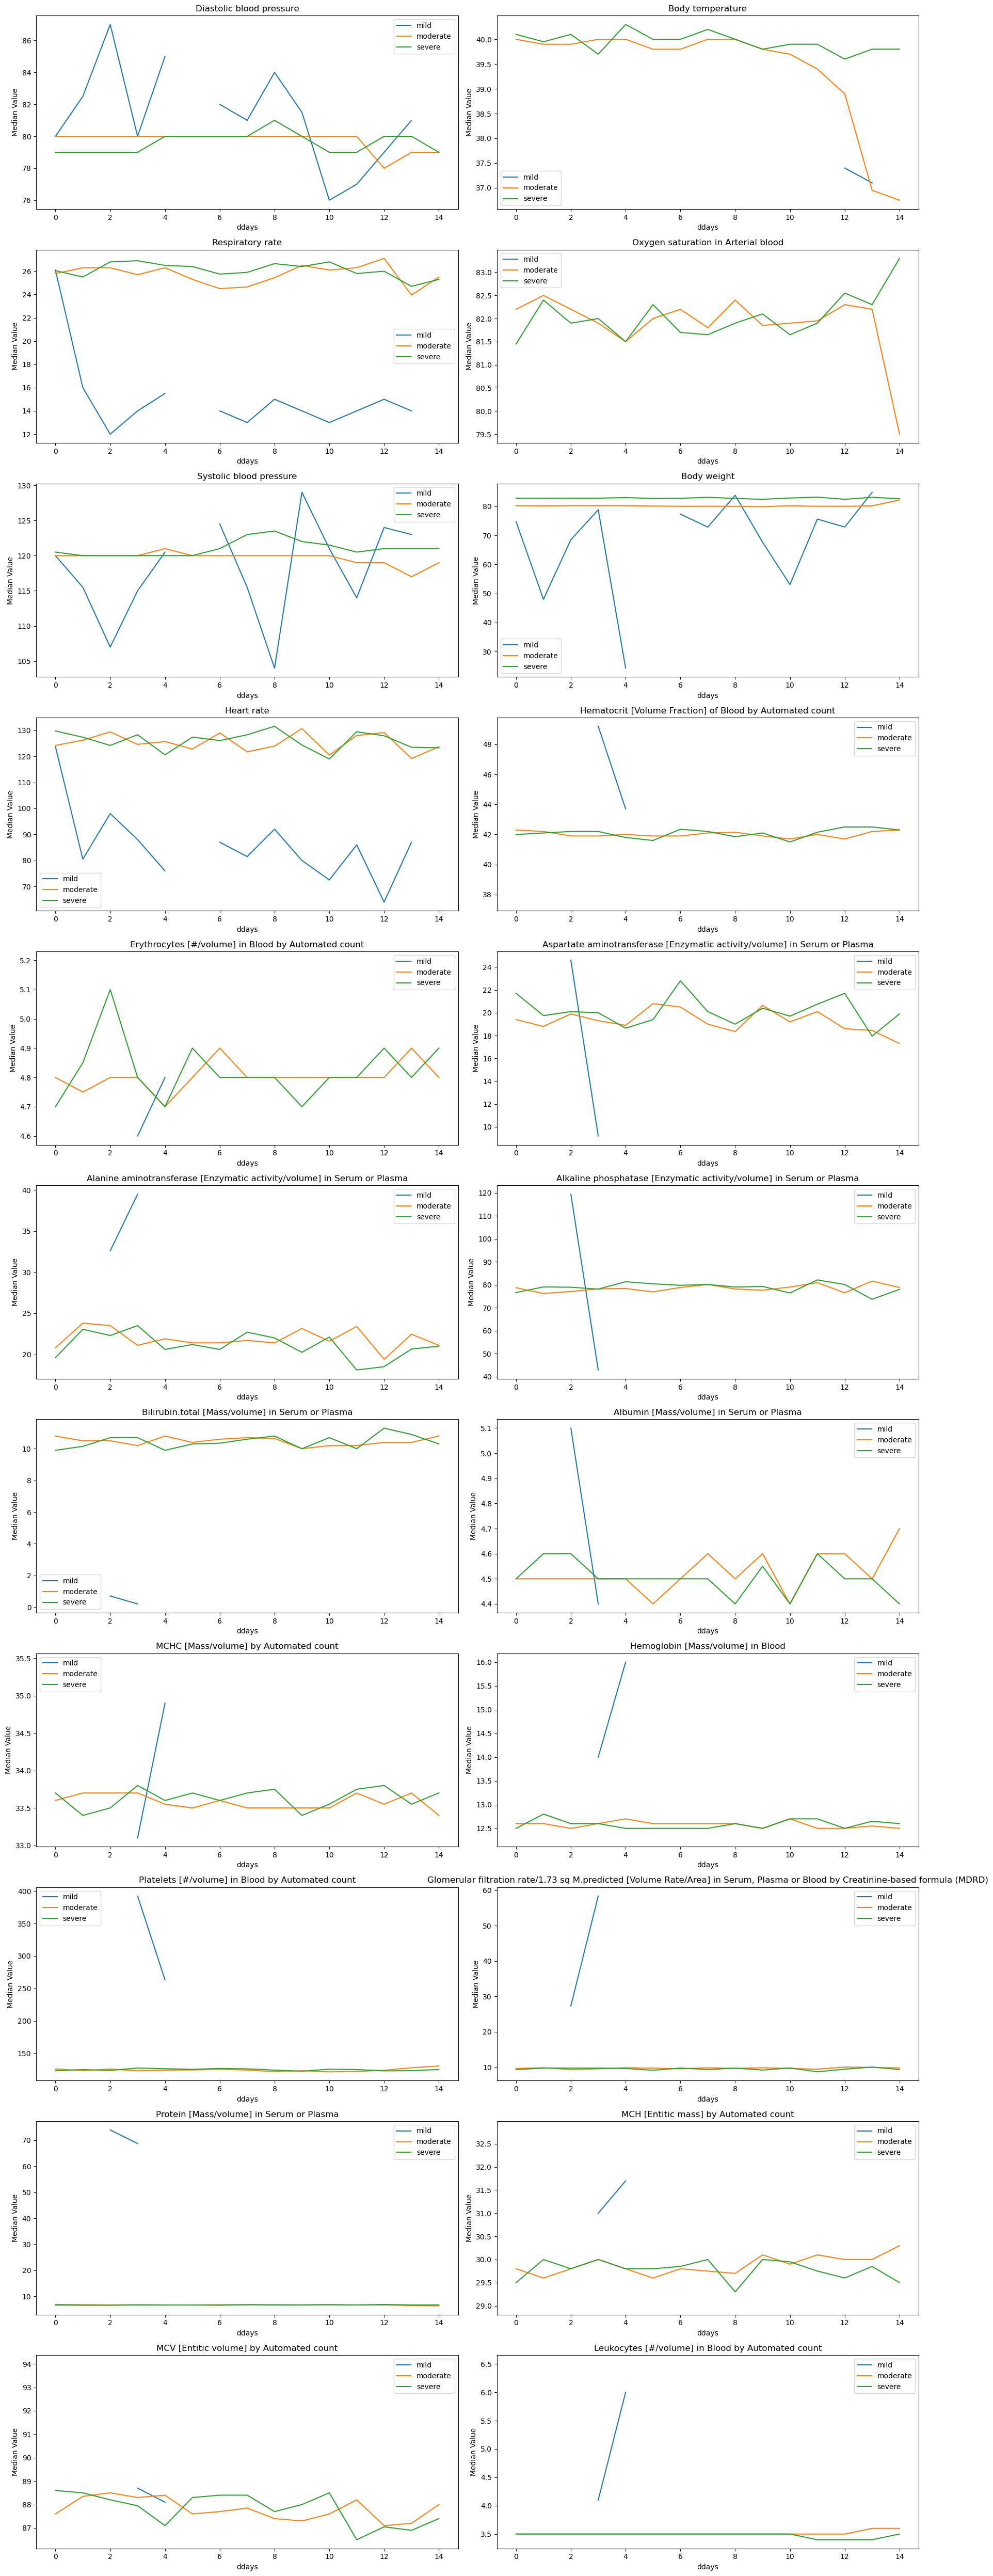

In [279]:
# List of measurements
measurement_names = [
    'Diastolic blood pressure', 'Body temperature', 'Respiratory rate',
    'Oxygen saturation in Arterial blood', 'Systolic blood pressure',
    'Body weight', 'Heart rate',
    'Hematocrit [Volume Fraction] of Blood by Automated count',
    'Erythrocytes [#/volume] in Blood by Automated count',
    'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma',
    'Bilirubin.total [Mass/volume] in Serum or Plasma',
    'Albumin [Mass/volume] in Serum or Plasma',
    'MCHC [Mass/volume] by Automated count',
    'Hemoglobin [Mass/volume] in Blood',
    'Platelets [#/volume] in Blood by Automated count',
    'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (MDRD)',
    'Protein [Mass/volume] in Serum or Plasma',
    'MCH [Entitic mass] by Automated count',
    'MCV [Entitic volume] by Automated count',
    'Leukocytes [#/volume] in Blood by Automated count'
]

plt.figure(figsize=(18, 50))  

for i, measurement in enumerate(measurement_names, start=1):
    plt.subplot(11, 2, i)  # Create a subplot for each measurement
    plt.title(measurement)
    plt.xlabel('Days Since Infection')
    plt.ylabel('Median Value')

    # Create a DataFrame to hold median values for each category
    median_values = pd.DataFrame(range(15), columns=['ddays'])

    # Calculate median for each category
    for cat in ['mild', 'moderate', 'severe']:
        median_values[cat] = get_stats(person_data, cat, measurement)['median']
    
    # Plot
    median_values.plot(x='ddays', y=['mild', 'moderate', 'severe'], ax=plt.gca())  # Use ax parameter to plot on current subplot

plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()  # Show the entire figure with all subplots


End of Notebook